In [18]:
import pandas as pd
from string import punctuation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
import pickle
from tensorflow.keras.layers import Input,Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPool1D,BatchNormalization

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
data=pd.read_csv("/kaggle/input/toxicity/train.csv")

In [20]:
# Function to remove URLs and IP addresses
def remove_urls_and_ip(text):
    text = re.sub(r'http\S+|www.\S+|\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)
    return text  

In [21]:
# Function to perform lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [22]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [23]:
# Iterate over each row in the 'column_text' column
for index, row in data.iterrows():
    text = row['comment_text']
    text = text.lower() # Convert the text to lowercase
    text = re.sub(r'\w*\d\w*', '', text) # Removing Characters in between Text
    text = re.sub(r'(.)\1+', r'\1', text) # Removing Repeated Characters
    text = text.translate(str.maketrans('', '', punctuation)) # Punctuation removal
    text = re.sub(r'\d+', '', text) # Number removal
    text = re.sub(r'\s+', ' ', text)# Removing unnecessary white spaces in between words
    text = text.replace('\n', ' ') # Removing "\n"
    text = re.sub(r'[^\x00-\x7F]+', '', text)# Removing Non-English characters
    text = remove_urls_and_ip(text)# Removing URLs and IP addresses
    #text = lemmatize_text(text)# Lemmatization
    stop_words = set(stopwords.words('english'))# Stopwords removal
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    data.at[index, 'comment_text'] = text # Update the DataFrame with the modified text


In [24]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daw matches background colour im semingly stuc...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im realy trying edit war guy constantl...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real sugestions improvement wondered...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


In [25]:
# Words to exclude
excluded_words = ['i', 'a', 'am', 'an', 'as', 'at', 'be', 'by', 'do', 'go', 'he', 'hi', 'if', 'is', 'in',
                  'me', 'my', 'no', 'of', 'on', 'or', 'ok', 'so', 'to', 'up', 'us', 'we']

In [26]:
def filter_words(text):
    words = re.findall(r'\b\w+\b', text)  # Extract words using regex
    filtered_words = [word for word in words if len(word) > 2 or word.lower() in excluded_words]
    return ' '.join(filtered_words)

In [27]:
data['comment_text'] = data['comment_text'].apply(filter_words)

In [28]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daw matches background colour semingly stuck t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realy trying edit war guy constantly r...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real sugestions improvement wondered...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


In [31]:
embedding_file = '/kaggle/input/embeddings-fast-text/wiki-news-300d-1M (1).vec'

In [32]:
def load_vectors(fname):
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

In [33]:
embedding_data = load_vectors(embedding_file)

In [34]:
max_features=100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['comment_text'])
sequences = tokenizer.texts_to_sequences(data['comment_text'])
word_index=tokenizer.word_index

In [35]:
max_sequence_length = 200
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length,padding = 'post')

In [36]:
embedding_dim_fasttext = 300
embeddings_index_fasttext = {}
f = open('/kaggle/input/embeddings-fast-text/wiki-news-300d-1M (1).vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector

In [37]:
#embedding_dim = len(next(iter(embedding_data.values())))

In [38]:
#vocab_size=(len(tokenizer.word_index) + 1)

In [39]:
#embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [40]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daw matches background colour semingly stuck t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realy trying edit war guy constantly r...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real sugestions improvement wondered...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


In [41]:
#with open('/kaggle/input/tokenizer', 'wb') as f:
  #  pickle.dump(tokenizer, f)

In [42]:
#word_embeddings = load_vectors('/content/drive/MyDrive/MSCI-741-Project/wiki-news-300d-1M.vec')

In [43]:
#embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
#for word, i in tokenizer.word_index.items():
   # if word in word_embeddings:
     #   embedding_matrix[i] = word_embeddings[word]

In [44]:
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [45]:
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']], test_size=0.2)

In [46]:
inp=Input(shape=(max_sequence_length, ),dtype='int32')

In [29]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = max_sequence_length,
                           trainable=False,
                           name = 'embeddings')

In [30]:
embedded_sequences = embedding_layer(inp)
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

#Compile the Model.
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [31]:
model=model_1.fit(X_train,y_train, epochs=3, batch_size=32,  validation_data=(X_val, y_val))


Epoch 1/3
3990/3990 [==============================] - 453s 113ms/step - loss: 0.0714 - accuracy: 0.9298 - val_loss: 0.0552 - val_accuracy: 0.9938
Epoch 2/3
3990/3990 [==============================] - 446s 112ms/step - loss: 0.0540 - accuracy: 0.9858 - val_loss: 0.0518 - val_accuracy: 0.9938
Epoch 3/3
3990/3990 [==============================] - 446s 112ms/step - loss: 0.0507 - accuracy: 0.9817 - val_loss: 0.0499 - val_accuracy: 0.9938


In [32]:
train_accuracy = model_1.evaluate(X_train, y_train)
print('Train Accuracy:', train_accuracy)



3990/3990 [==============================] - 158s 40ms/step - loss: 0.0447 - accuracy: 0.9943
Train Accuracy: [0.04465728625655174, 0.9942579865455627]


In [ ]:
val_accuracy = model_1.evaluate(X_val, y_val)
print('Validation Accuracy:', val_accuracy)

998/998 [==============================] - 258s 259ms/step - loss: 0.1387 - accuracy: 0.9937

Validation Accuracy: [0.13872067630290985, 0.9937019944190979]


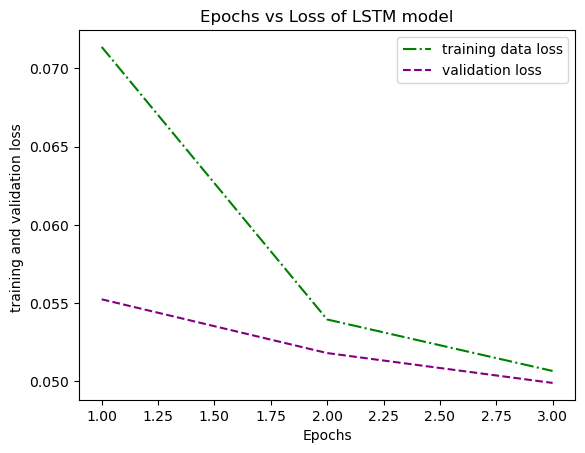

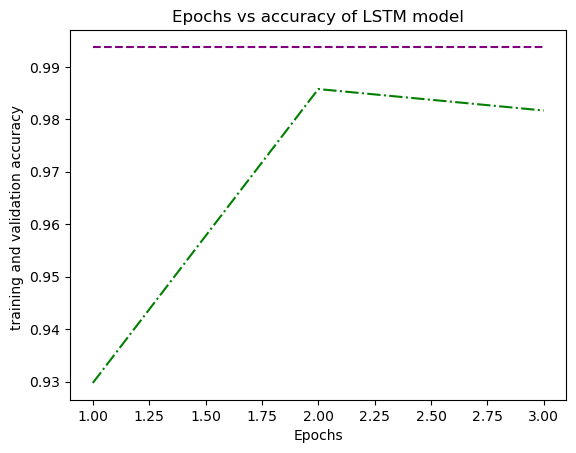

In [61]:
import matplotlib.pyplot as py
training_loss = model.history['loss']
validation_loss = model.history['val_loss']
training_accuracy = model.history['accuracy']
validation_accuracy = model.history['val_accuracy']

epochs = range(1,4)
py.plot(epochs,training_loss,color='green',linestyle="dashdot",label = "training data loss")
py.plot(epochs,validation_loss,color='purple',linestyle="dashed",label = "validation loss")

py.xlabel("Epochs")
py.ylabel("training and validation loss ")
py.title("Epochs vs Loss of LSTM model")
py.legend()
py.show()

py.plot(epochs,training_accuracy,color='green',linestyle="dashdot",label = "training data accuracy")
py.plot(epochs,validation_accuracy,color='purple',linestyle="dashed",label = "validation accracy")
py.xlabel("Epochs")
py.ylabel("training and validation accuracy ")
py.title("Epochs vs accuracy of LSTM model")
py.show()

In [48]:
model_1.save('/kaggle/working/toxic_comment_model_lstm_phase_1.h5')

In [2]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [47]:
test_labels = pd.read_csv('/kaggle/input/toxicity/test_labels.csv')
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [48]:
test_comments=pd.read_csv("/kaggle/input/toxicity/test.csv")
test_comments

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [49]:
result = pd.merge(test_comments, test_labels, on='id', how='inner')
result

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


In [50]:
result  = result.drop(result[result['toxic'] == -1].index)
result

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [51]:
model = load_model('/kaggle/input/indrajits-trainedlstm/Indrajits_LSTM_Trained_model.h5')

In [52]:
# Iterate over each row in the 'column_text' column
for index, row in result.iterrows():
    text = row['comment_text']
    text = text.lower() # Convert the text to lowercase
    text = re.sub(r'\w*\d\w*', '', text) # Removing Characters in between Text
    text = re.sub(r'(.)\1+', r'\1', text) # Removing Repeated Characters
    text = text.translate(str.maketrans('', '', punctuation)) # Punctuation removal
    text = re.sub(r'\d+', '', text) # Number removal
    text = re.sub(r'\s+', ' ', text)# Removing unnecessary white spaces in between words
    text = text.replace('\n', ' ') # Removing "\n"
    text = re.sub(r'[^\x00-\x7F]+', '', text)# Removing Non-English characters
    text = remove_urls_and_ip(text)# Removing URLs and IP addresses
    #text = lemmatize_text(text)# Lemmatization
    stop_words = set(stopwords.words('english'))# Stopwords removal
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    result.at[index, 'comment_text'] = text # Update the DataFrame with the modified text


In [53]:
test_comments=result

In [54]:
test_comments['comment_text'] = test_comments['comment_text'].apply(filter_words)

In [55]:
test_comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,thank understanding think highly would revert ...,0,0,0,0,0,0
7,000247e83dcc1211,dear god site horible,0,0,0,0,0,0
11,0002f87b16116a7f,somebody wil invariably try religion realy mea...,0,0,0,0,0,0
13,0003e1cccfd5a40a,says right type type institution neded case th...,0,0,0,0,0,0
14,00059ace3e3e9a53,ading new product list make sure relevant adin...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,jerome never got around surprised loked exampl...,0,0,0,0,0,0
153151,fff9d70fe0722906,lucky bastard htpwikimediafoundationorgwikipre...,0,0,0,0,0,0
153154,fffa8a11c4378854,shame want speak gays romanians,0,0,0,0,0,0
153155,fffac2a094c8e0e2,mel gibson nazi bitch makes shity movies much ...,1,0,1,0,1,0


In [56]:
sequences = tokenizer.texts_to_sequences(test_comments['comment_text'])

In [57]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [58]:
max_sequence_length

200

In [59]:
max_index = len(tokenizer.word_index)
max_index

211649

In [61]:
invalid_indices = [index for sequence in sequences for index in sequence if index > max_index]
if len(invalid_indices) > 0:
    print('Invalid indices detected in the sequences:', invalid_indices)
    print('Please check the tokenizer and input data.')

else:
    # Make predictions on the test data
    predictions = model.predict(padded_sequences)
    predicted_labels = [round(pred[0]) for pred in predictions]



2000/2000 [==============================] - 54s 27ms/step


In [62]:
for i in range(6):
    precision_score(labels[:, i])

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [47]:
predictions

array([[9.88801956e-01, 2.71943420e-01, 8.96555245e-01, 2.14494720e-01,
        7.67859817e-01, 3.22671562e-01],
       [2.67437473e-02, 4.25220642e-05, 2.95898039e-03, 2.59263790e-04,
        3.51591595e-03, 1.02596963e-03],
       [3.70760709e-02, 1.05060964e-04, 5.40037779e-03, 5.67691342e-04,
        6.14675786e-03, 1.73871696e-03],
       ...,
       [7.85721652e-03, 3.31084652e-06, 8.27407872e-04, 2.54330589e-05,
        7.19347154e-04, 1.47000115e-04],
       [2.39760950e-02, 1.88114991e-05, 1.64909218e-03, 1.46045306e-04,
        2.03415402e-03, 3.15981382e-03],
       [1.43258974e-01, 4.70722734e-04, 1.83735564e-02, 2.08737911e-03,
        2.87557282e-02, 4.70578764e-03]], dtype=float32)

In [ ]:
# array([[9.8168459e-03, 9.3143630e-05, 4.5146164e-03, 1.5243600e-04,
#         2.4073482e-03, 4.6165581e-04],
#        [2.1318111e-01, 4.5107650e-03, 8.9934081e-02, 5.7109194e-03,
#         8.7633491e-02, 1.0909560e-02],
#        [3.3163214e-01, 4.5185997e-03, 1.4806442e-01, 4.1517620e-03,
#         1.3675998e-01, 3.7452590e-02],
#        ...,
#        [8.4205812e-01, 1.5321815e-01, 4.1994739e-01, 9.5238432e-02,
#         5.1940447e-01, 5.3912127e-01],
#        [9.6734017e-01, 9.8398119e-02, 8.7760133e-01, 1.8004142e-02,
#         7.3934162e-01, 1.4225906e-01],
#        [6.5020934e-02, 6.1904348e-04, 2.7378391e-02, 9.0075948e-04,
#         1.7172588e-02, 4.7653383e-03]], dtype=float32)

In [63]:
max_value = np.max(predictions)
print("Maximum value:", max_value)

Maximum value: 0.9999658


In [64]:
min_value = np.min(predictions)
print("Minimum value:", min_value)

Minimum value: 8.457494e-09


In [65]:
mask = predictions > 0.5

In [66]:
modified_predictions = np.where(mask, 1, 0)

In [67]:
modified_predictions

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 1, 1],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [68]:
test_labels=result[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
test_labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0
...,...,...,...,...,...,...
153150,0,0,0,0,0,0
153151,0,0,0,0,0,0
153154,0,0,0,0,0,0
153155,1,0,1,0,1,0


In [69]:
test_labels.values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [70]:
test_labels.values.flatten()

array([0, 0, 0, ..., 0, 0, 0])

In [71]:
 accuracy = accuracy_score(test_labels.values, modified_predictions)

In [72]:
print('Accuracy:', accuracy)

Accuracy: 0.8941667448185314


In [73]:
from sklearn.metrics import precision_score,recall_score,roc_auc_score,f1_score

In [104]:
precision = precision_score(test_labels.values, modified_predictions,average='micro')
recall = recall_score(test_labels.values, modified_predictions,average='micro')
f1 = f1_score(test_labels.values, modified_predictions,average='micro')
print("precision = ",precision,"recall = ",recall,"f1 score = ",f1)

precision =  0.6787709497206704 recall =  0.5698717064422679 f1 score =  0.6195725534308212


In [101]:
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print(f"The precision score of '{column}': {precision}")
    

The precision score of 'toxic': 0.9348305736396043
The precision score of 'severe_toxic': 0.992673888618867
The precision score of 'obscene': 0.9622635159795115
The precision score of 'threat': 0.9934148594803478
The precision score of 'insult': 0.9575197977153068
The precision score of 'identity_hate': 0.9890113004674114


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    print(f"The recall score of '{column}': {recall}")
    

The recall score of 'toxic': 0.932789396354997
The recall score of 'severe_toxic': 0.994248022757823
The recall score of 'obscene': 0.9646753571540216
The recall score of 'threat': 0.9967019913095126
The recall score of 'insult': 0.9621744974835099
The recall score of 'identity_hate': 0.9908249710838101


In [103]:
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f"The recall score of '{column}': {f1}")

The recall score of 'toxic': 0.9337368312804998
The recall score of 'severe_toxic': 0.9931605712266722
The recall score of 'obscene': 0.9630974211753426
The recall score of 'threat': 0.995055710671004
The recall score of 'insult': 0.9581888080421503
The recall score of 'identity_hate': 0.9888361826279073


false positive rate =  [0.         0.04057836 1.        ]
true positive rate =  [0.         0.67963875 1.        ]
threshold =  [2 1 0]
roc_auc =  0.8195301969217951


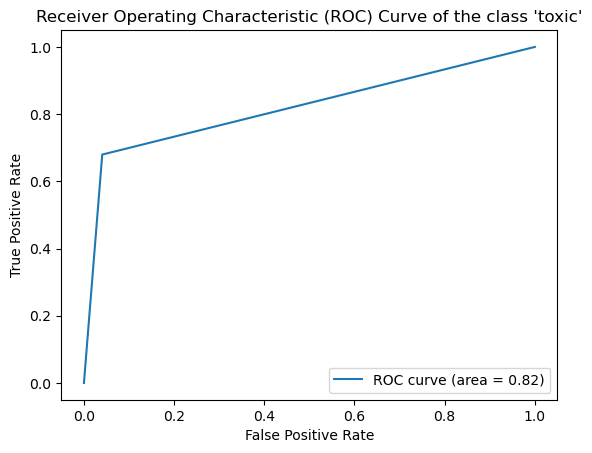

false positive rate =  [0.         0.00130481 1.        ]
true positive rate =  [0.         0.22343324 1.        ]
threshold =  [2 1 0]
roc_auc =  0.6110642183671127


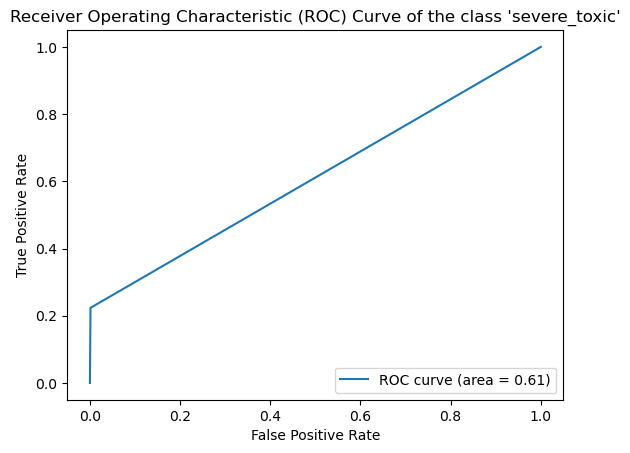

false positive rate =  [0.         0.01345232 1.        ]
true positive rate =  [0.         0.60742346 1.        ]
threshold =  [2 1 0]
roc_auc =  0.7969855713695184


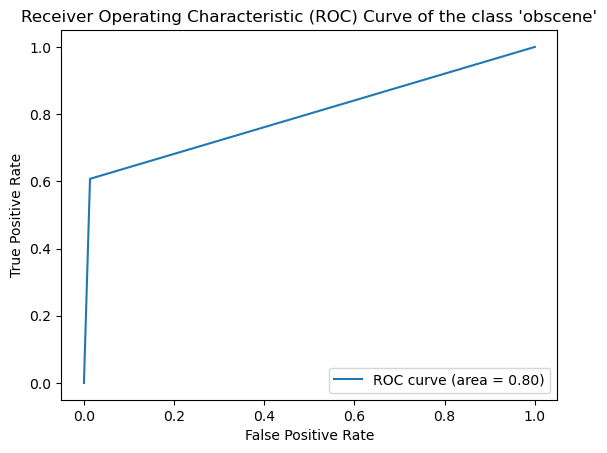

false positive rate =  [0. 1.]
true positive rate =  [0. 1.]
threshold =  [1 0]
roc_auc =  0.5


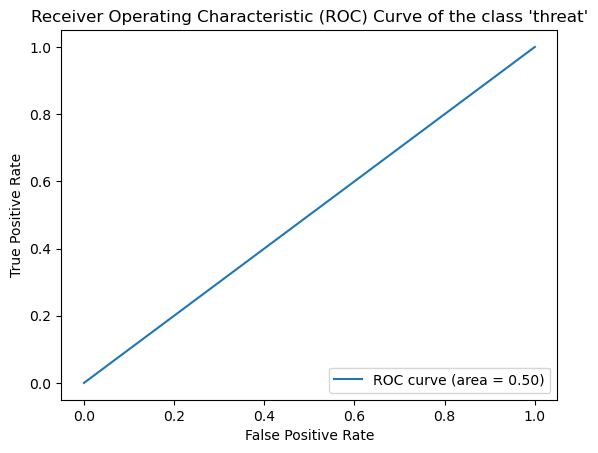

false positive rate =  [0.         0.00974385 1.        ]
true positive rate =  [0.         0.46600525 1.        ]
threshold =  [2 1 0]
roc_auc =  0.728130700058774


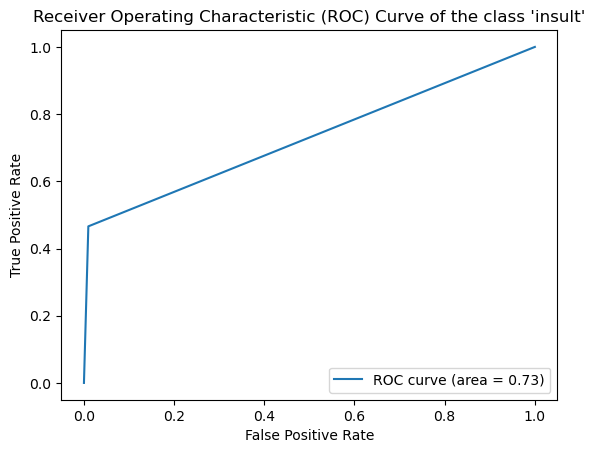

false positive rate =  [0.         0.00121708 1.        ]
true positive rate =  [0.         0.28370787 1.        ]
threshold =  [2 1 0]
roc_auc =  0.6412453908715013


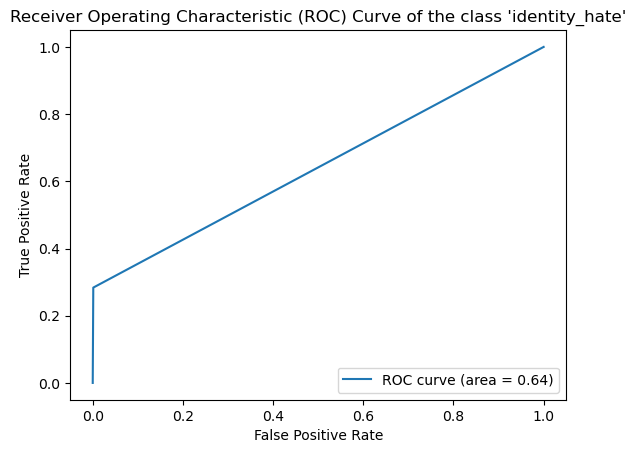

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    false_pos_rate, true_pos_rate, t = roc_curve(true_labels,predicted_labels)
    print("false positive rate = ",false_pos_rate)
    print("true positive rate = ",true_pos_rate)
    print("threshold = ",t)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    print("roc_auc = ",roc_auc)
    # Plot the ROC curve
    plt.figure()
    plt.plot(false_pos_rate, true_pos_rate, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve of the class '{column}'")
    plt.legend(loc='lower right')
    plt.show()


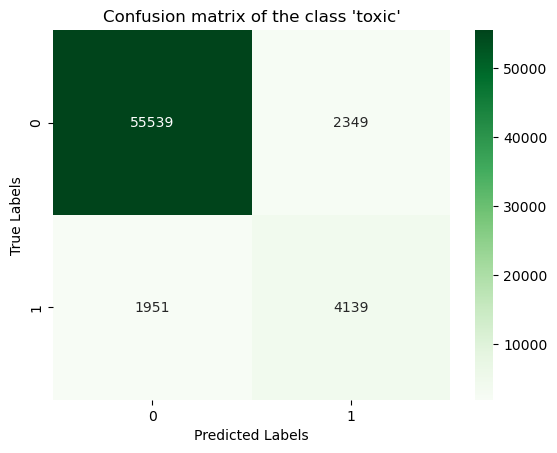

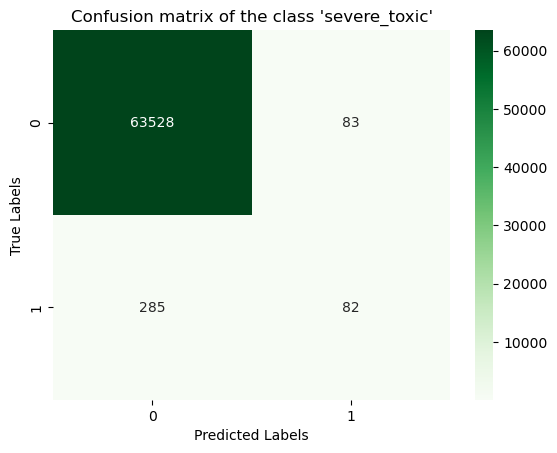

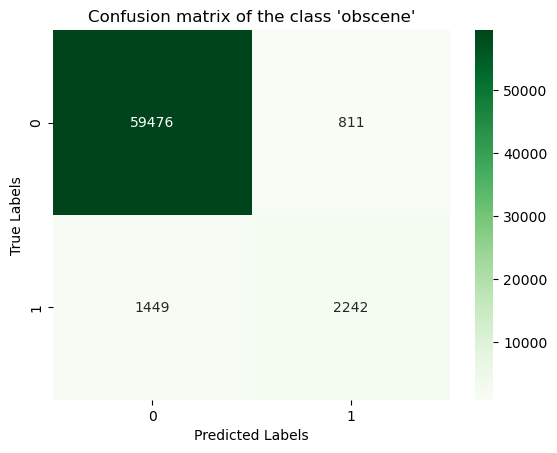

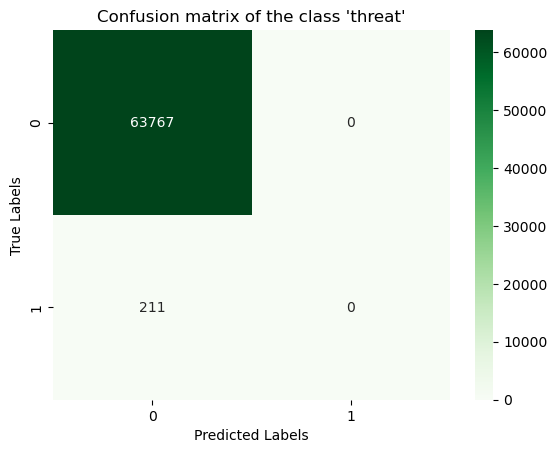

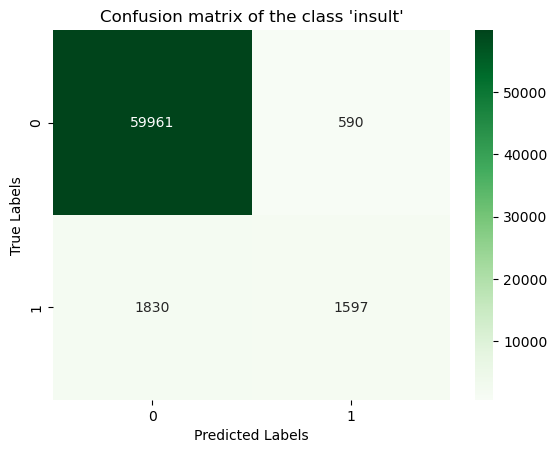

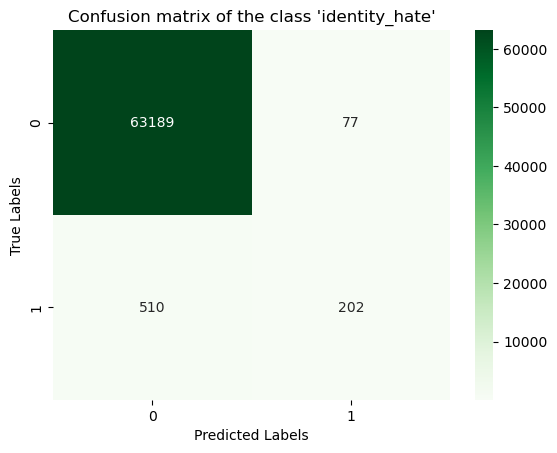

In [113]:
import seaborn as sns
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion matrix of the class '{column}'")
    plt.show()
